Starting with only the closing price dataset to see if the model I make actually works or not, then I will make use of the other three datasets if needed. 

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping

# Load the dataset
# Assuming you have the dataset in a CSV file
file_path = '/Users/rafayhaque/Documents/QMind/Stocks_AdjClose_10yr.csv'  
df = pd.read_csv(file_path, index_col='Date', parse_dates=True)
df.head()

#volume_path = '/Users/rafayhaque/Documents/QMind/Stocks_Volume_10yr.csv'
#volume_df = pd.read_csv(volume_path, index_col='Date', parse_dates=True)

# Combine volume and price data into a single DataFrame
#combined_df = pd.concat([df, volume_df], axis=1)

# Scale the combined dataset
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.values)



def create_sequences(data, sequence_length):
    xs = []
    ys = []
    for i in range(len(data)-sequence_length):
        x_part = data[i:i+sequence_length]
        y_part = data[i+sequence_length]
        xs.append(x_part)
        ys.append(y_part)
    return np.array(xs), np.array(ys)

# Choose a sequence length
sequence_length = 100  # Number of days to use for prediction. Adjust as needed.

# Create the sequences
X, y = create_sequences(scaled_data, sequence_length)

train_size = int(len(X) * 0.8)  # 80% for training, 20% for testing
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

early_stopping = EarlyStopping(
    monitor='val_loss',  # monitors the validation loss
    patience=5,          # stops training after 5 epochs without improvement in val_loss
    restore_best_weights=True  # restores model weights from the epoch with the best value of the monitored quantity
)


model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, X.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(X.shape[2]))  # The output layer should have the same number of neurons as features

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error',)


history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=100,
    validation_split=0.1,
    callbacks=[early_stopping]  # Include the callback here
)
#44 epochs

loss = model.evaluate(X_test, y_test)

# Make predictions
predictions = model.predict(X_test)

# Inverse transform to get actual prices
actual_predictions = scaler.inverse_transform(predictions)
actual_y_test = scaler.inverse_transform(y_test)

SyntaxError: positional argument follows keyword argument (903144941.py, line 60)

16/16 [==============================] - 0s 17ms/step
Mean Squared Error: 8498.422663074978
Root Mean Squared Error: 92.18688986550625
Mean Absolute Error: 39.57120539359017


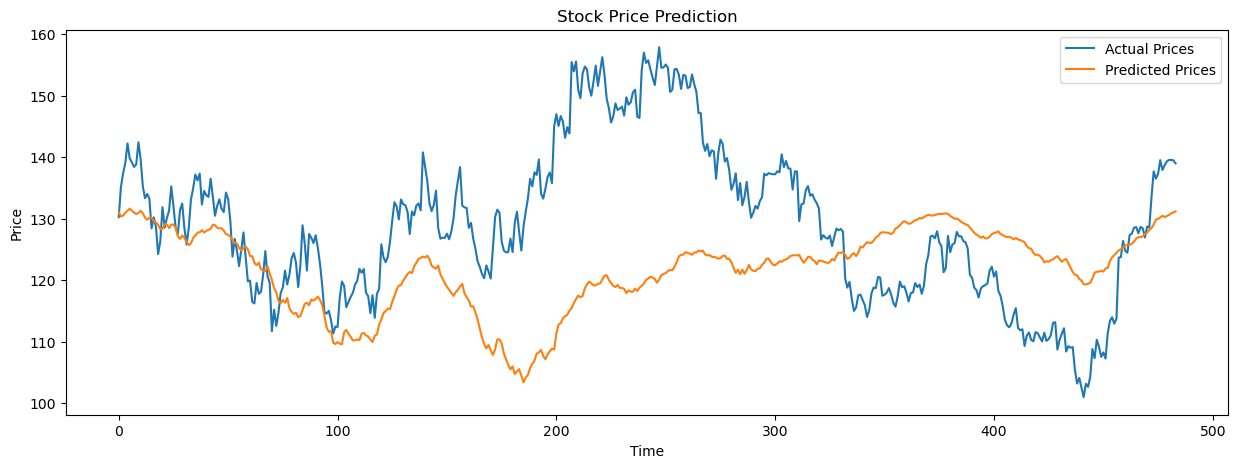

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Make predictions
predictions = model.predict(X_test)

# Inverse the scaling to get the actual predictions
predicted_prices = scaler.inverse_transform(predictions)
real_prices = scaler.inverse_transform(y_test)

# Calculate performance metrics
mse = mean_squared_error(real_prices, predicted_prices)
rmse = np.sqrt(mse)
mae = mean_absolute_error(real_prices, predicted_prices)

# Print the metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")

# Plot the real vs predicted values
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(real_prices[:, 0], label='Actual Prices')  # change 0 to the index of the stock you want to plot
plt.plot(predicted_prices[:, 0], label='Predicted Prices')  # change 0 to the index of the stock you want to plot
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

16/16 [==============================] - 0s 17ms/step
Mean Squared Error for AAPL: 1692.9999978831074
Root Mean Squared Error for AAPL: 41.146081197157855
Mean Absolute Error for AAPL: 38.99419306895862


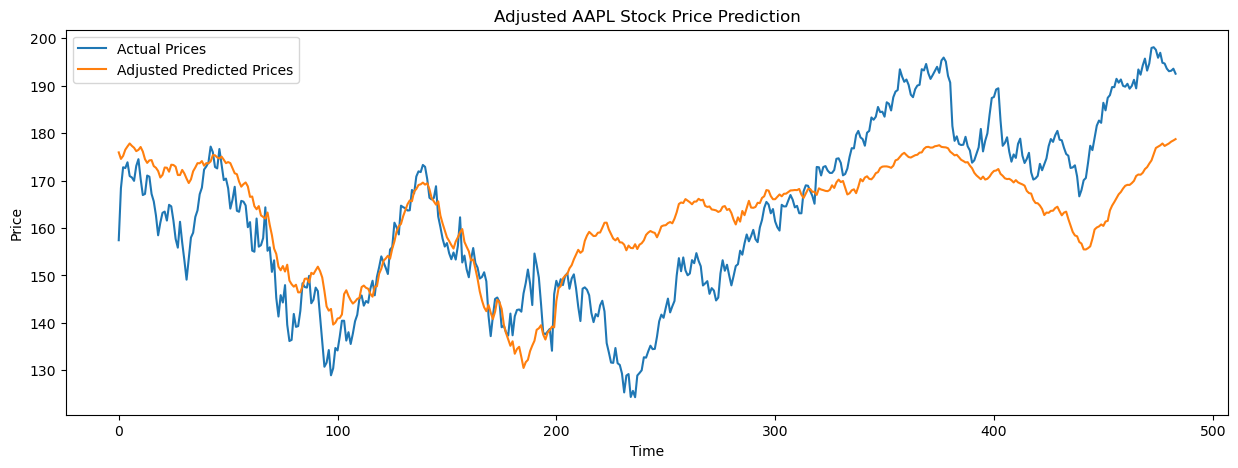

In [8]:
stock_index = df.columns.get_loc("AAPL")  # replace 'AAPL' with your stock ticker

# Make predictions for all stocks
predictions = model.predict(X_test)

# Inverse transform to get actual prices for all stocks
actual_predictions = scaler.inverse_transform(predictions)
actual_y_test = scaler.inverse_transform(y_test)

# Extract the predictions for the selected stock
selected_stock_predictions = actual_predictions[:, stock_index]
selected_stock_real = actual_y_test[:, stock_index]

# Calculate performance metrics for the selected stock
mse = mean_squared_error(selected_stock_real, selected_stock_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(selected_stock_real, selected_stock_predictions)

# Print the metrics for the selected stock
print(f"Mean Squared Error for {df.columns[stock_index]}: {mse}")
print(f"Root Mean Squared Error for {df.columns[stock_index]}: {rmse}")
print(f"Mean Absolute Error for {df.columns[stock_index]}: {mae}")

# Calculate the adjustment factor based on mean values
adjustment_factor = selected_stock_real.mean() / selected_stock_predictions.mean()

# Apply the adjustment factor to the predictions
adjusted_predictions = selected_stock_predictions * adjustment_factor

# Plot the adjusted predictions
plt.figure(figsize=(15, 5))
plt.plot(selected_stock_real, label='Actual Prices')
plt.plot(adjusted_predictions, label='Adjusted Predicted Prices')
plt.title(f'Adjusted {df.columns[stock_index]} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


1/1 [==============================] - 0s 12ms/step


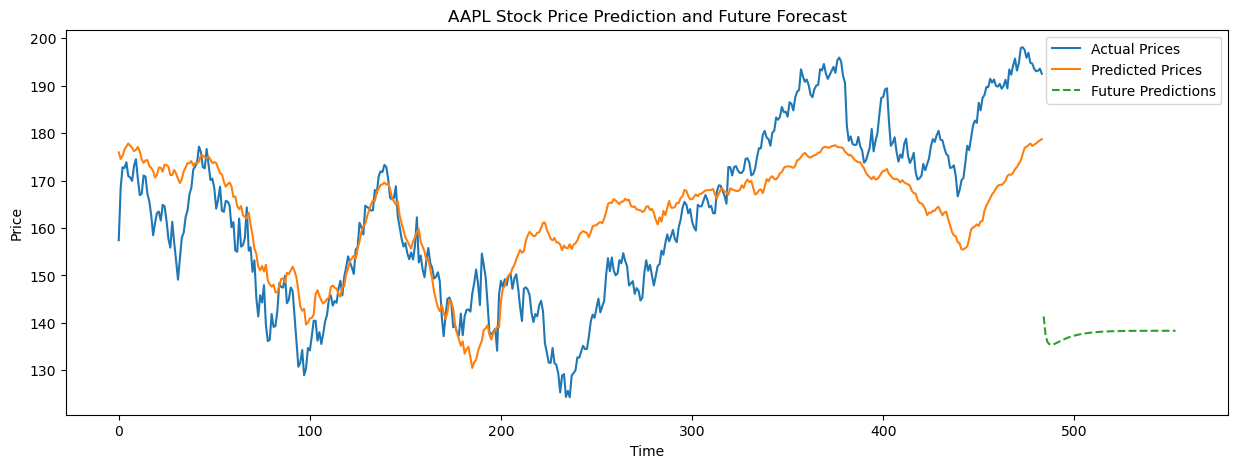

In [14]:
n_future_steps = 70  # For example, predict 30 days into the future

# Get the last sequence from X_test (assuming X_test is ordered chronologically)
last_sequence = X[-1:]  # Take the last sequence for prediction

new_predictions = []
for _ in range(n_future_steps):
    # Predict the next step
    next_step_prediction = model.predict(last_sequence)
    
    # Append the prediction to the new_predictions list
    new_predictions.append(next_step_prediction[0])
    
    # Update the last_sequence with the predicted value
    last_sequence = np.append(last_sequence[:, 1:, :], [next_step_prediction], axis=1)

# Now, new_predictions contains your future predictions in scaled form
# Convert new_predictions to a numpy array for inverse transformation
new_predictions_array = np.array(new_predictions)

# If your scaler was fit on the original dataset with multiple features/columns,
# you need to prepare the data for inverse transformation properly
if df.shape[1] > 1:
    # We need to create a dummy array with the same shape as the training data
    dummy_array = np.zeros((len(new_predictions_array), df.shape[1]))
    # Place the predictions in the correct column
    dummy_array[:, stock_index] = new_predictions_array[:, 0]
    # Now, inverse transform using the dummy array
    new_predictions_inversed = scaler.inverse_transform(dummy_array)[:, stock_index]
else:
    # If your dataset only contains one feature, you can directly inverse transform
    new_predictions_inversed = scaler.inverse_transform(new_predictions_array)

# Calculate the adjustment factor based on mean values
adjustment_factor = selected_stock_real.mean() / selected_stock_predictions.mean()

# Apply the adjustment factor to the predictions
adjusted_predictions = selected_stock_predictions * adjustment_factor

# Plotting the results
plt.figure(figsize=(15, 5))
plt.plot(range(len(selected_stock_real)), selected_stock_real, label='Actual Prices')
plt.plot(range(len(selected_stock_real)), adjusted_predictions, label='Predicted Prices')
# Plot future predictions
plt.plot(range(len(selected_stock_real), len(selected_stock_real) + n_future_steps), new_predictions_inversed, label='Future Predictions', linestyle="--")
plt.title(f'{df.columns[stock_index]} Stock Price Prediction and Future Forecast')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


NEXT STEPS: Refine this model, try new things, different parameters, find similar models to use and imrpove this, include volume, splits, dividiends as features, scale properly, train more, then check predicitons again.